In [236]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from gtda.diagrams import PersistenceEntropy, Amplitude, NumberOfPoints, ComplexPolynomial, PersistenceLandscape, HeatKernel, Silhouette, BettiCurve, PairwiseDistance, PersistenceImage 
from gtda.plotting import plot_point_cloud
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns
from hausdorff import hausdorff_distance
import numpy as np
import pickle as pickle
import gudhi as gd  
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import norm
from sklearn.decomposition import KernelPCA
import plotly.io as pio


%matplotlib inline

# Choose EEG or EMG

In [2]:
# Choose if you want to look at EEG or EMG data

data_type = "EEG" # Does not have an effect yet, will be added later when processing anesthesia data
#data_type = "EMG"

In [3]:
# choose individuum
subject = "m292"

# Load data

In [4]:
label_list = [0, 1, 2, 3, 4]

In [5]:
data = np.load('Data/'+str(subject)+'/Data.npy', allow_pickle=True).item()

In [6]:
# All features
feature_df  = pd.read_csv("Features/All_Features.csv")

In [10]:
persistence_diagrams  = np.load('Embeddings_and_Persistence_Diagrams/'+str(subject)+'/'+str(data_type)+'/Persistence_Diagrams_All_Labels.npy', \
    allow_pickle=True).item() # .item() to convert the dtype to dict again

# TODO do this in Preprocessing_And_Computing_...

reshaped_persistence_diagrams = {}

for label in label_list:
    reshaped_persistence_diagrams["Label_"+str(label)] = [persistence_diagram[0] for persistence_diagram in list(persistence_diagrams["Label_"+str(label)])]

persistence_diagrams = reshaped_persistence_diagrams

In [11]:
extended_persistence_diagrams  = np.load('Embeddings_and_Persistence_Diagrams/'+str(subject)+'/'+str(data_type)+'/Extended_Persistence_Diagrams_All_Labels.npy', \
    allow_pickle=True).item() # .item() to convert the dtype to dict again

In [11]:
"""
# Load barycenters

wasserstein_barycenters = [] # dictionary with labels as keys, persistence diagrams of the respective classes as values

for label in label_list:
    wasserstein_barycenters.append(np.load('Embeddings_and_Persistence_Diagrams/'+str(data_type)+'_wasserstein_Barycenter_class_'+str(label)+'.npy', allow_pickle=True)[0])

"""

"\n# Load barycenters\n\nwasserstein_barycenters = [] # dictionary with labels as keys, persistence diagrams of the respective classes as values\n\nfor label in label_list:\n    wasserstein_barycenters.append(np.load('Embeddings_and_Persistence_Diagrams/'+str(data_type)+'_wasserstein_Barycenter_class_'+str(label)+'.npy', allow_pickle=True)[0])\n\n"

# Plots directly from Time Series Data

## Plot time series of each label directly (complete)

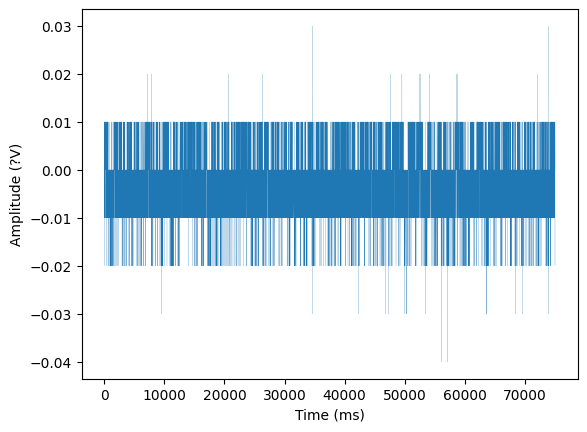

In [12]:
# Choose label 
label = 2

plt.plot(data[label]["emg"], linewidth=0.1)
plt.ylabel("Amplitude (?V)")
plt.xlabel("Time (ms)")
plt.xticks(ticks = [0, 20000,  40000,  60000,  80000,  100000,  120000,  140000], labels=[0, 10000,  20000,  30000,  40000,  50000,  60000,  70000])
plt.savefig('Plots/Example_EMG_Masterthesis.png')  # Save the plot as a PNG file
plt.show()

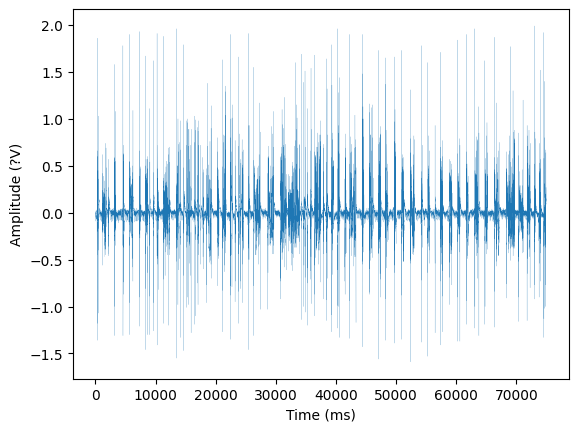

In [13]:
# Choose label 
label = 4

plt.plot(data[label]["voltage"], linewidth=0.1)
plt.ylabel("Amplitude (?V)")
plt.xlabel("Time (ms)")
plt.xticks(ticks = [0, 20000,  40000,  60000,  80000,  100000,  120000,  140000], labels=[0, 10000,  20000,  30000,  40000,  50000,  60000,  70000])
plt.savefig('Plots/Example_EEG_Masterthesis.png')  # Save the plot as a PNG file
plt.show()

## Plot time series of each label directly (partly)

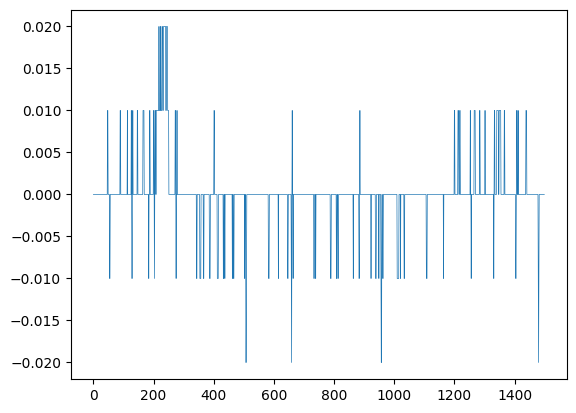

In [14]:
label = 0

# Plot parts of the time series
plt.plot(data[label]["emg"][:1500], linewidth=0.5)

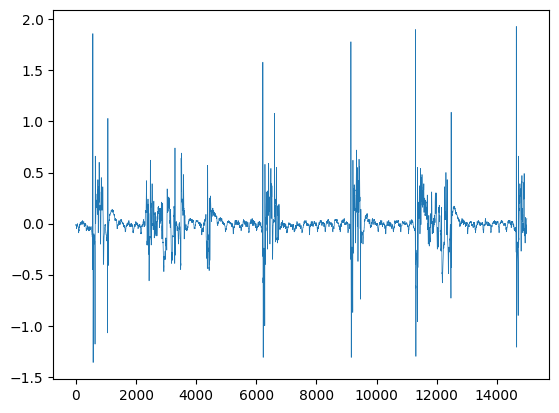

In [15]:
# Choose label 
label = 4

# Plot parts of the time series
plt.plot(data[label]["voltage"][:15000], linewidth=0.5)

The higher the anesthesia level, the higher the frequency.

## Finding clusters in signatures

In [18]:
feature_df.columns

Index(['Unnamed: 0', 'EEG_Persistence Entropy_Dim_0',
       'EEG_Persistence Entropy_Dim_1', 'EEG_Persistence Entropy_Dim_2',
       'EEG_Amplitude_Dim_0', 'EEG_Amplitude_Dim_1', 'EEG_Amplitude_Dim_2',
       'EEG_No_Points_Dim_0', 'EEG_No_Points_Dim_1', 'EEG_No_Points_Dim_2',
       'EEG_Largest_Persistence_Dim_0', 'EEG_Largest_Persistence_Dim_1',
       'EEG_Largest_Persistence_Dim_2', 'Label',
       'EMG_Persistence Entropy_Dim_0', 'EMG_Persistence Entropy_Dim_1',
       'EMG_Persistence Entropy_Dim_2', 'EMG_Amplitude_Dim_0',
       'EMG_Amplitude_Dim_1', 'EMG_Amplitude_Dim_2', 'EMG_No_Points_Dim_0',
       'EMG_No_Points_Dim_1', 'EMG_No_Points_Dim_2',
       'EMG_Largest_Persistence_Dim_0', 'EMG_Largest_Persistence_Dim_1',
       'EMG_Largest_Persistence_Dim_2', 'Label.1', 'Subject'],
      dtype='object')

## Correlation between Time Series and L1 norm of the signatures (Experimental)

This approach follows the idea of...

In [94]:
# Choose label
label = 4

In [101]:
# Choose signature here
SG = BettiCurve()
scaling_factor = 0.000005

#SG = BettiCurve()
#scaling_factor = 0.000000007

L1_norms = []


for diagram in persistence_diagrams["Label_"+str(label)]:
    signature = SG.fit_transform([diagram])
    L1_norms.append(scaling_factor*norm(signature[0][0], 1)) # scale TODO later introduce different y axes

In [102]:
ts_segments_means = []

for idx in range(len(L1_norms)):
    # take average of all means
    ts_segments_means.append(np.mean(data[label]["voltage"][2000*idx:2000*(idx+1)]))

The correlation is -0.0010369.


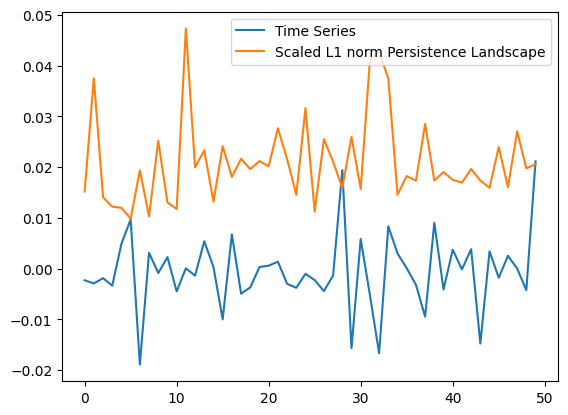

In [103]:
correlation = np.corrcoef(ts_segments_means, L1_norms)[0][1]
print("The correlation is " + str(round(correlation, 7))+".")

plt.plot(ts_segments_means[:50], label = "Time Series") 
plt.plot(L1_norms[:50], label = "Scaled L1 norm Persistence Landscape")
plt.legend()
plt.show()

In [104]:
(0.2082892+0.0884915+0.1722664+0.0700136+0.0010369)/5

0.10801952

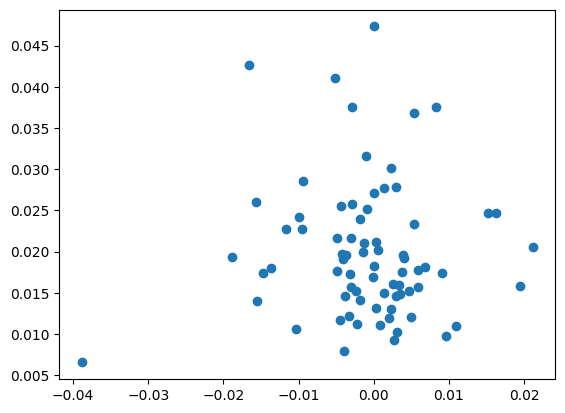

In [105]:
plt.scatter(ts_segments_means, L1_norms)

## Result

Average absolute correlation across labels: 0.0643225 => No significant correlation.

# Create simplicial complexes (Experimental)

First, we plot the mean embeddings of each class as point clouds (of which we later want to see the simplicial complexes).

In [21]:
# TODO this has to be done with embedding dimension 3

mean_embeddings = {}

for label in label_list:
    mean_embeddings[label] = np.mean(embeddings["Label_"+str(label)], axis=0)

NameError: name 'embeddings' is not defined

In [ ]:
# Label 0
plot_point_cloud(mean_embeddings[0])

In [ ]:
# Label 4
plot_point_cloud(mean_embeddings[4])

Now create simplicial complexes (Vietoris-Rips and alpha complexes) and visualize alpha complexes.

In [ ]:
# Label 0
# Vietoris-Rips complex
skeleton = gd.RipsComplex(points = mean_embeddings[0], max_edge_length = 0.2)
Rips_simplex_tree_sample = skeleton.create_simplex_tree(max_dimension = 3) 

# alpha complex
ac = gd.AlphaComplex(points=mean_embeddings[0])
st = ac.create_simplex_tree()

points = np.array([ac.get_point(i) for i in range(st.num_vertices())])
# We want to plot the alpha-complex with alpha=0.005 by default.
# We are only going to plot the triangles
triangles = np.array([s[0] for s in st.get_skeleton(2) if len(s[0]) == 3 and s[1] <= 0.005])

In [ ]:
# Visualization with matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider

# TODO does this have a small scaling?
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
l = ax.plot_trisurf(points[:, 0], points[:, 1], points[:, 2], triangles = triangles)

plt.show()

In [ ]:
# Label 4

# Vietoris-Rips complex
skeleton = gd.RipsComplex(points = mean_embeddings[4], max_edge_length = 0.2)
Rips_simplex_tree_sample = skeleton.create_simplex_tree(max_dimension = 3) 

# alpha complex
ac = gd.AlphaComplex(points=mean_embeddings[4])
st = ac.create_simplex_tree()

points = np.array([ac.get_point(i) for i in range(st.num_vertices())])
# We want to plot the alpha-complex with alpha=0.005 by default.
# We are only going to plot the triangles
triangles = np.array([s[0] for s in st.get_skeleton(2) if len(s[0]) == 3 and s[1] <= 0.005])

In [ ]:
# Visualization with matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
l = ax.plot_trisurf(points[:, 0], points[:, 1], points[:, 2], triangles = triangles)

plt.show()

## Gromov Hausdorff distances between the simplicial complexes?

Later look at something like correlations between geometric and topological distances.

In [106]:
skeleton = []
for s in st.get_skeleton(2):
    skeleton.append(s)

NameError: name 'st' is not defined

In [107]:
len(skeleton)

0

# Dissimilarity matrices of features

In [108]:
feature_df.columns

Index(['Unnamed: 0', 'EEG_Persistence Entropy_Dim_0',
       'EEG_Persistence Entropy_Dim_1', 'EEG_Persistence Entropy_Dim_2',
       'EEG_Amplitude_Dim_0', 'EEG_Amplitude_Dim_1', 'EEG_Amplitude_Dim_2',
       'EEG_No_Points_Dim_0', 'EEG_No_Points_Dim_1', 'EEG_No_Points_Dim_2',
       'EEG_Largest_Persistence_Dim_0', 'EEG_Largest_Persistence_Dim_1',
       'EEG_Largest_Persistence_Dim_2', 'Label',
       'EMG_Persistence Entropy_Dim_0', 'EMG_Persistence Entropy_Dim_1',
       'EMG_Persistence Entropy_Dim_2', 'EMG_Amplitude_Dim_0',
       'EMG_Amplitude_Dim_1', 'EMG_Amplitude_Dim_2', 'EMG_No_Points_Dim_0',
       'EMG_No_Points_Dim_1', 'EMG_No_Points_Dim_2',
       'EMG_Largest_Persistence_Dim_0', 'EMG_Largest_Persistence_Dim_1',
       'EMG_Largest_Persistence_Dim_2', 'Label.1', 'Subject'],
      dtype='object')

In [109]:
# Get mean values of the features for each label

label = 0

mean_df = pd.DataFrame()

for label in label_list:
    filtered_df = feature_df[feature_df["Label"] == label]
    mean_df = pd.concat([mean_df, pd.DataFrame(filtered_df.describe().loc["mean"]).transpose()])

## Several features and pairwise label comparison

Does not always make sense because the features have such different scalings. But can make sense for features that, in principle, consist of several columns, like "HK_Vectorization_Dim_xCoord_y"

In [113]:
# Look at a set of features

features_list = ["Persistence Entropy_Dim_0", "Persistence Entropy_Dim_1", "Persistence Entropy_Dim_2"]

/var/folders/f_/tyg450s17m53dh3ylrjcmpqc0000gn/T/ipykernel_14533/3316685219.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  z = np.array([complex(mean_df["EEG_"+feature][mean_df["Label"] == labelx], mean_df["EMG_"+feature][mean_df["Label"] == labely]) for feature in features_list])


<Axes: >

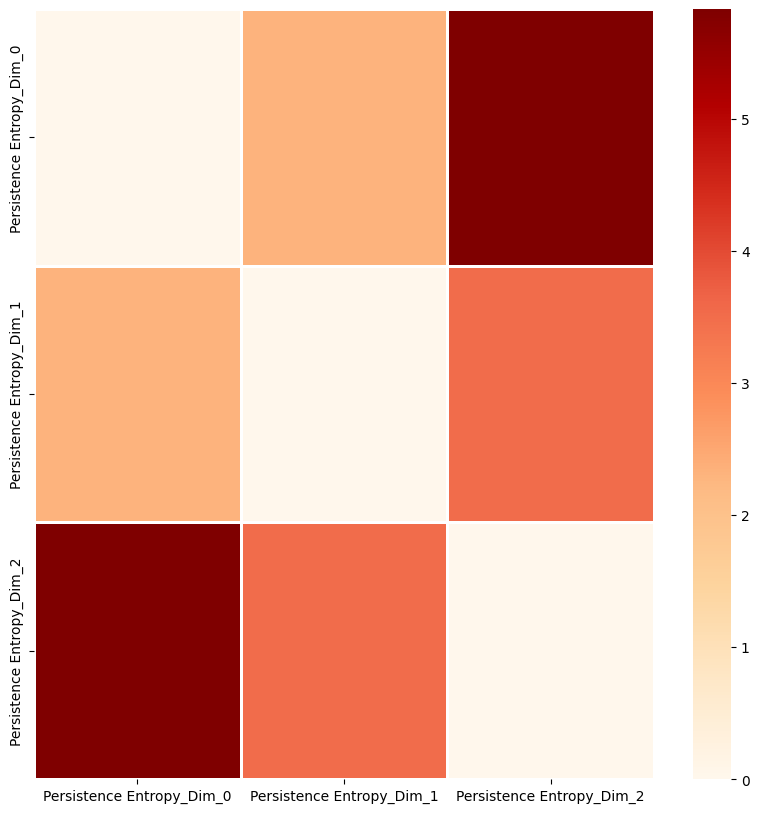

In [116]:
# Distance matrix between label 0 and 4

labelx = 0
labely = 4

z = np.array([complex(mean_df["EEG_"+feature][mean_df["Label"] == labelx], mean_df["EMG_"+feature][mean_df["Label"] == labely]) for feature in features_list])

m, n = np.meshgrid(z, z)
# get the distance via the norm
distance_matrix = abs(m-n)

# plot it with seaborn
plt.figure(figsize=(10,10))
sns.heatmap(
    distance_matrix,
    cmap='OrRd',
    linewidth=1,
    xticklabels = features_list,
    yticklabels = features_list
)

## One feature and all labels

/var/folders/f_/tyg450s17m53dh3ylrjcmpqc0000gn/T/ipykernel_14533/472167917.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  z = np.array([complex(mean_df[feature][mean_df["Label"] == label], mean_df[feature][mean_df["Label"] == label]) for label in [0, 1, 2, 3, 4]])


<Axes: >

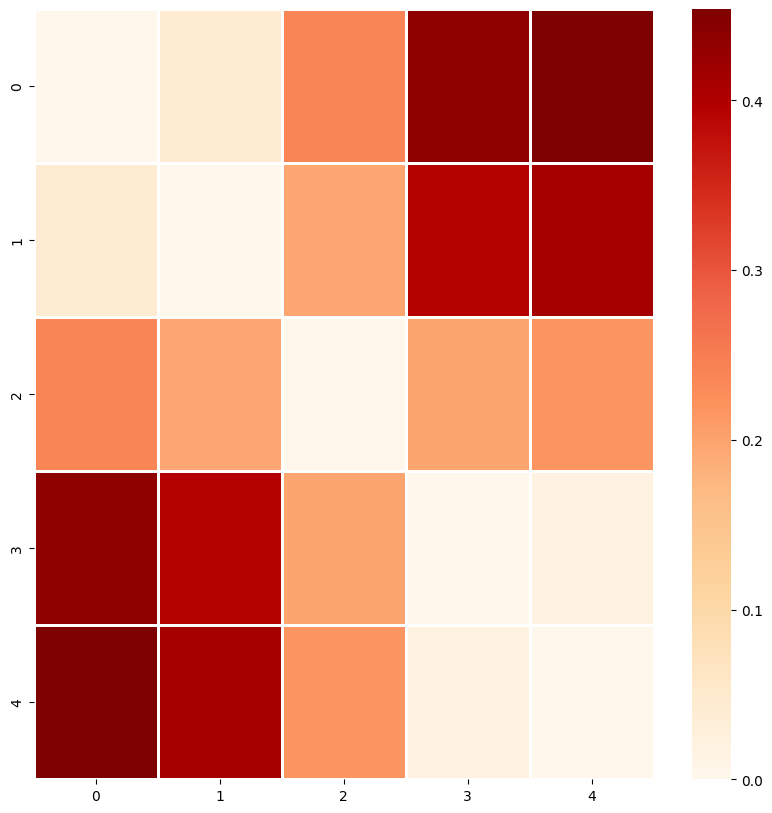

In [118]:
# Choose one feature
feature = "EEG_Persistence Entropy_Dim_0"

# Don't consider label 7 because it will destroy the scaling 
z = np.array([complex(mean_df[feature][mean_df["Label"] == label], mean_df[feature][mean_df["Label"] == label]) for label in [0, 1, 2, 3, 4]])

m, n = np.meshgrid(z, z)
# get the distance via the norm
distance_matrix = abs(m-n)

# plot it with seaborn
plt.figure(figsize=(10,10))
sns.heatmap(
    distance_matrix,
    cmap='OrRd',
    linewidth=1,
    xticklabels = [0, 1, 2, 3, 4],
    yticklabels = [0, 1, 2, 3, 4]
)

## Dissimilarity matrix of barycenters

In [ ]:
# Wasserstein barycenter
pairwise_distances = PairwiseDistance(metric="wasserstein").fit_transform(wasserstein_barycenters)

# plot it with seaborn
plt.figure(figsize=(10,10))
sns.heatmap(
    pairwise_distances,
    cmap='OrRd',
    linewidth=1,
    xticklabels = [1, 3, 5, 7],
    yticklabels = [1, 3, 5, 7]
)

## Box plots

In [ ]:
#feature_df.columns

In [ ]:
# Choose feature to plot box plot

feature = "EMG_Persistence Entropy_Dim_2"

explored_feature = []
explored_feature.append(feature_df[feature][feature_df["Label"] == 0])
explored_feature.append(feature_df[feature][feature_df["Label"] == 1])
explored_feature.append(feature_df[feature][feature_df["Label"] == 2])
explored_feature.append(feature_df[feature][feature_df["Label"] == 3])
explored_feature.append(feature_df[feature][feature_df["Label"] == 4])

plt.boxplot(explored_feature)

# show plot
plt.title("Distribution of Amplitude of Persistence Entropy of Dimension 2 over Anesthesia Levels (EMG)")
plt.xticks(ticks = [1, 2,  3,  4, 5], labels=["Label 0", "Label 1",  "Label 2", "Label 3", "Label 4"])
plt.savefig('Plots/Box_Plot_'+str(feature)+'.png')
plt.show()


# Signatures

## Heat Kernel

In [244]:
HK = HeatKernel(sigma=0.2, n_bins=100)

In [245]:
def heat_kernel_intensity(heatkernel, homology_dimension):
    """ Computes mean intensity of a heatkernel. Only takes positive values because otherwise the mean would
      always be zero.

    Parameters:
    - heatkernel (list of lists): heatkernel of all homology dimensions
    - homology_dimension (int): Which homology dimension to look at (0, 1 or 2)

    Returns:
    - mean intensity of heatkernel of homology dimension homology_dimension
    """
    
    positives =  [x for inner_list in heatkernel[0][homology_dimension] for x in inner_list if x > 0]
    
    return np.mean(positives)

In [249]:
label = 4
heatkernel = HK.fit_transform(extended_persistence_diagrams["Label_"+str(label)])

Heat kernel intensity of label 4  for homology dimension 0: 18.122267100034858


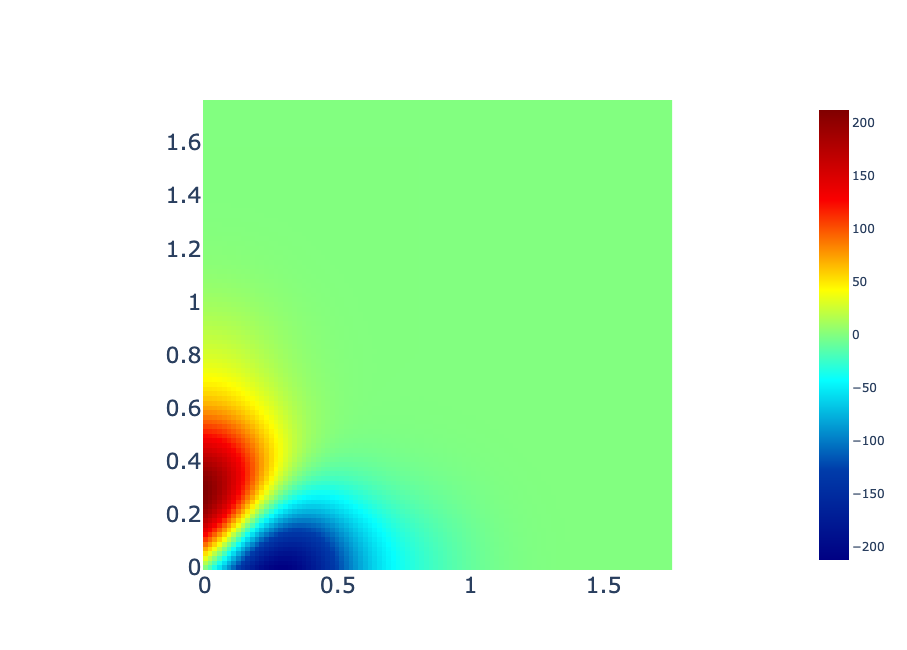

In [250]:
print("Heat kernel intensity of label "+str(label)+"  for homology dimension 0: " + str(heat_kernel_intensity(heatkernel, 0)))

plotly_params = {
    "layout": {
        "title": {
            "text": "",
            "x": 0.5,  # Ccenter the title horizontally
            "xanchor": "center",  # Anchor the title text at the center
        },
        "width": 800,  
        "height": 650,  
        "xaxis": {"tickfont": {"size": 22}}, 
        "yaxis": {"tickfont": {"size": 22}}    
    }
}


fig = HK.plot(heatkernel, homology_dimension_idx=0, colorscale='jet', plotly_params=plotly_params)

fig.show()

# Save the plot as an image (PNG format)
pio.write_image(fig, "Plots/EEG Heatkernel of Dimension 0 (Label "+str(label)+").png")

Heat kernel intensity of label 4  for homology dimension 1: 18.122267100034858


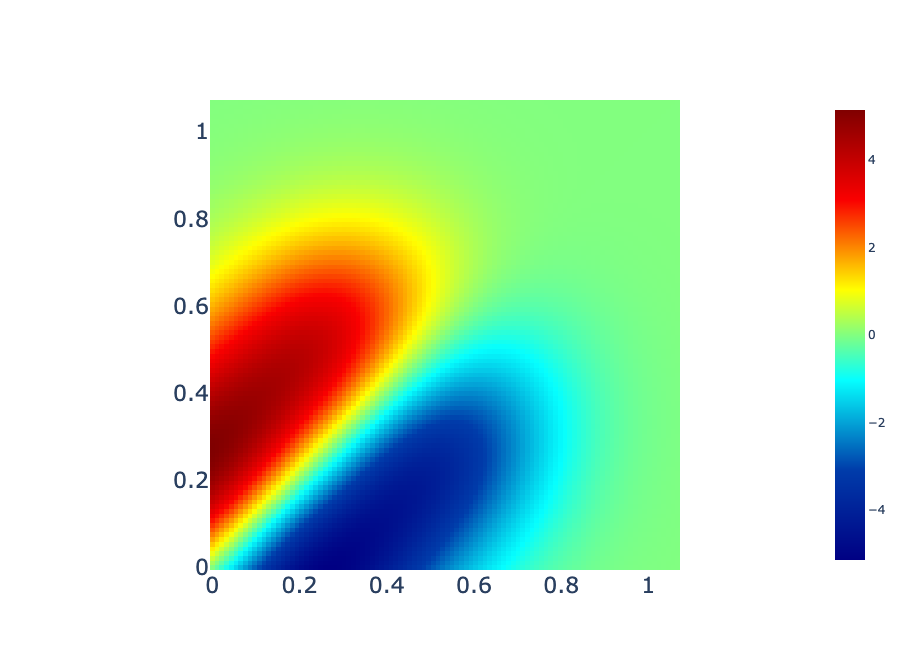

In [251]:
print("Heat kernel intensity of label "+str(label)+"  for homology dimension 1: " + str(heat_kernel_intensity(heatkernel, 0)))

plotly_params = {
    "layout": {
        "title": {
            "text": "",
            "x": 0.5,  # Ccenter the title horizontally
            "xanchor": "center",  # Anchor the title text at the center
        },
        "width": 800,  
        "height": 650,  
        "xaxis": {"tickfont": {"size": 22}}, 
        "yaxis": {"tickfont": {"size": 22}}    
    }
}


fig = HK.plot(heatkernel, homology_dimension_idx=1, colorscale='jet', plotly_params=plotly_params)

fig.show()

# Save the plot as an image (PNG format)
pio.write_image(fig, "Plots/EEG Heatkernel of Dimension 1 (Label "+str(label)+").png")

# Persistence Landscape

In [126]:
PL = PersistenceLandscape()

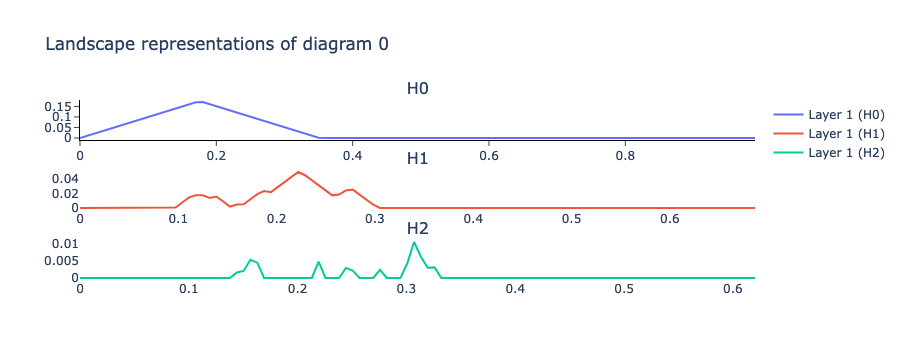

In [127]:
label = 0
landscape = PL.fit_transform(extended_persistence_diagrams["Label_"+str(label)])
PL.plot(landscape)

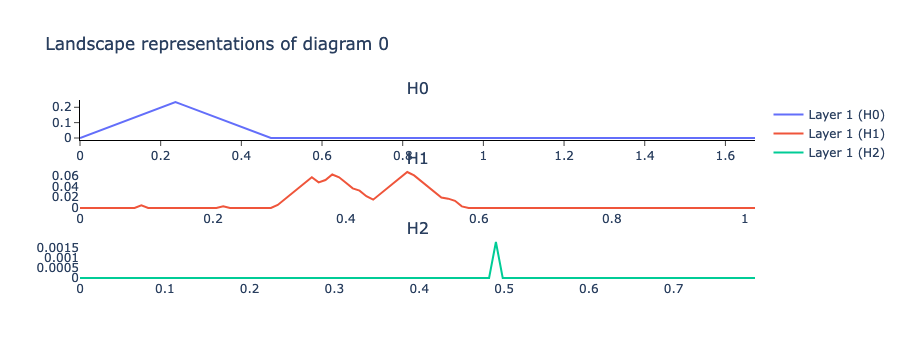

In [128]:
label = 2
landscape = PL.fit_transform(extended_persistence_diagrams["Label_"+str(label)])
PL.plot(landscape)

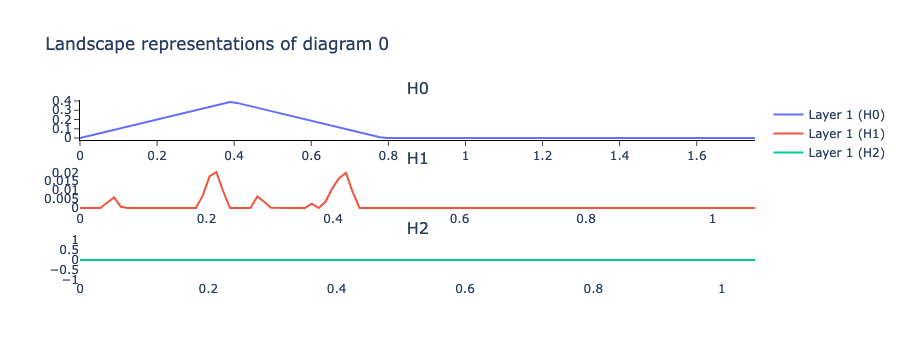

In [129]:
label = 4
landscape = PL.fit_transform(extended_persistence_diagrams["Label_"+str(label)])
PL.plot(landscape)

# Silhouette

In [130]:
SH = Silhouette()

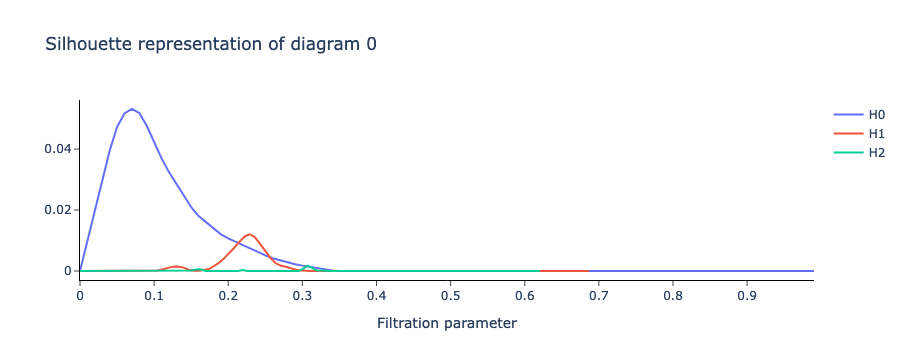

In [131]:
label = 0
silhouette = SH.fit_transform(extended_persistence_diagrams["Label_"+str(label)])
SH.plot(silhouette, homology_dimensions = [0, 1, 2])

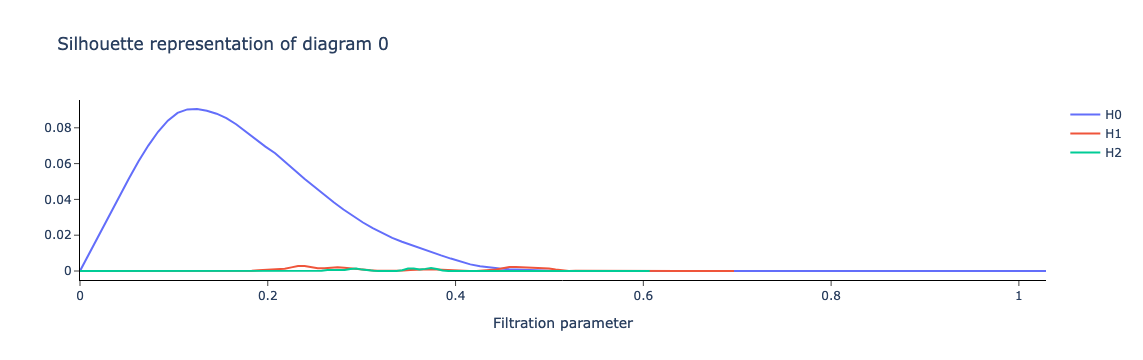

In [132]:
label = 1
silhouette = SH.fit_transform(extended_persistence_diagrams["Label_"+str(label)])
SH.plot(silhouette, homology_dimensions = [0, 1, 2])

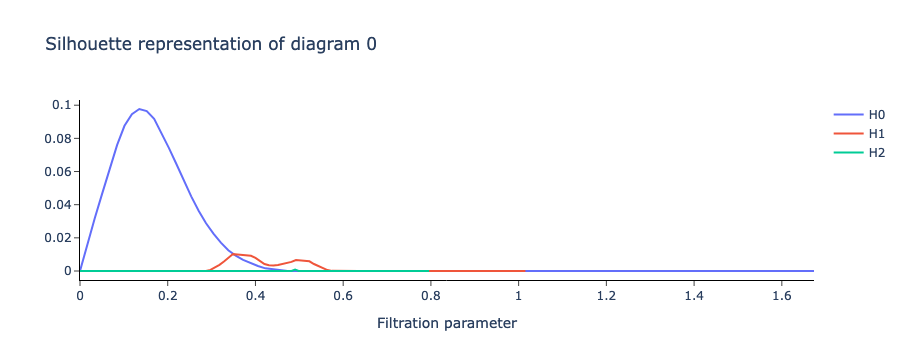

In [133]:
label = 2
silhouette = SH.fit_transform(extended_persistence_diagrams["Label_"+str(label)])
SH.plot(silhouette, homology_dimensions = [0, 1, 2])

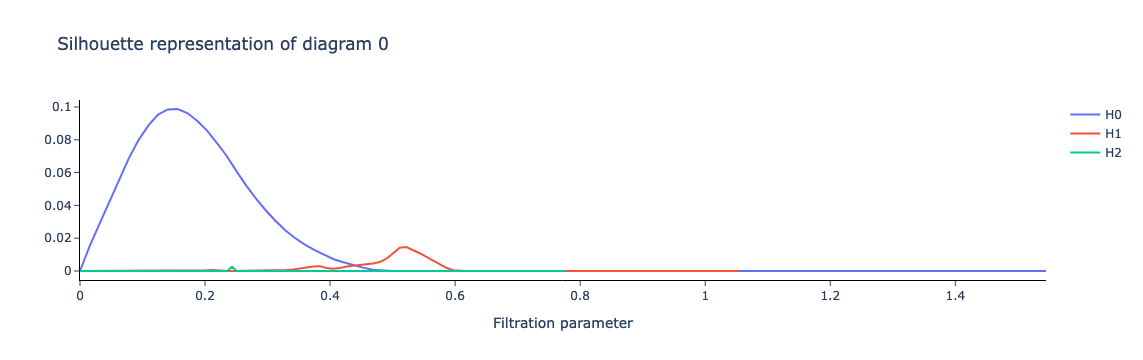

In [134]:
label = 3
silhouette = SH.fit_transform(extended_persistence_diagrams["Label_"+str(label)])
SH.plot(silhouette, homology_dimensions = [0, 1, 2])

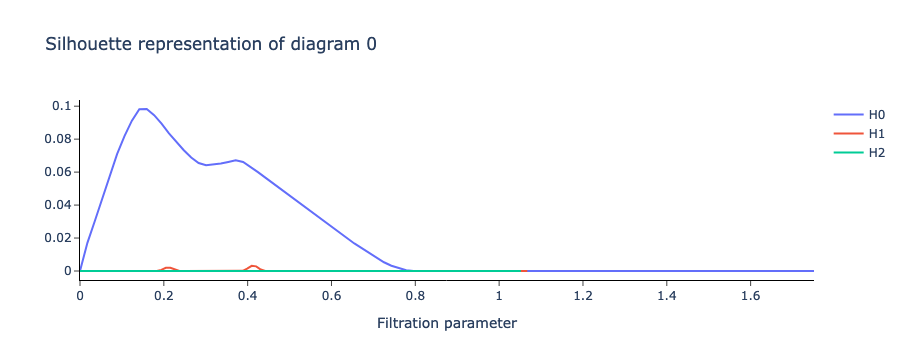

In [135]:
label = 4
silhouette = SH.fit_transform(extended_persistence_diagrams["Label_"+str(label)])

SH.plot(silhouette, homology_dimensions = [0, 1, 2])

# Betti Curve

In [136]:
BC = BettiCurve()

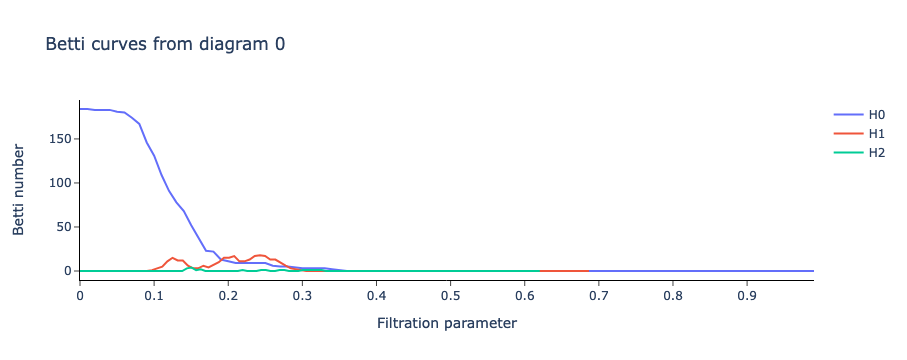

In [137]:
betti_curve = BC.fit_transform_plot(extended_persistence_diagrams["Label_0"])

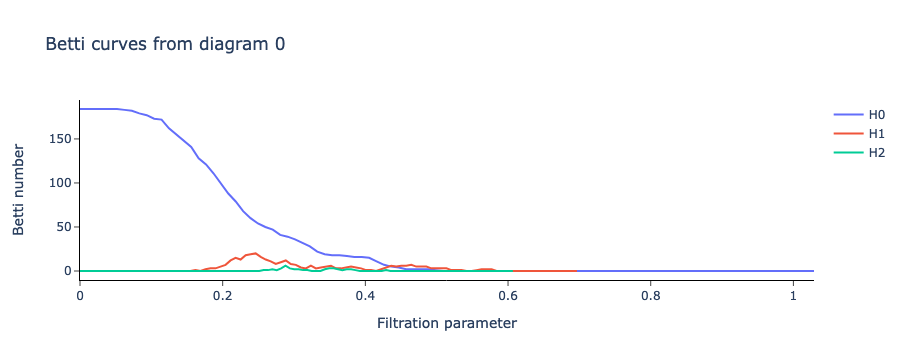

In [138]:
betti_curve = BC.fit_transform_plot(extended_persistence_diagrams["Label_1"])

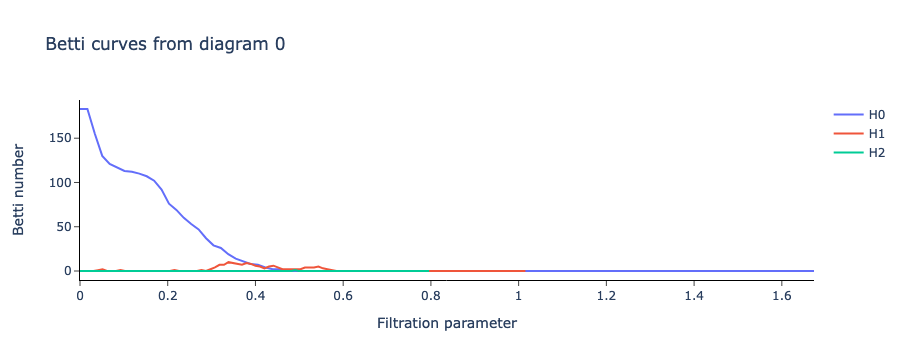

In [139]:
betti_curve = BC.fit_transform_plot(extended_persistence_diagrams["Label_2"])

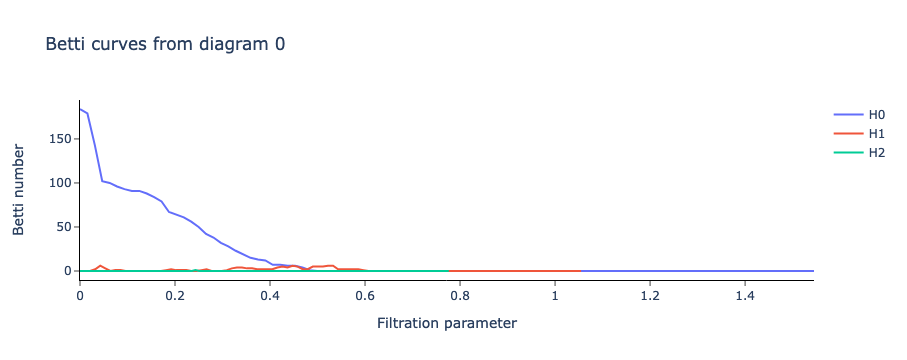

In [140]:
betti_curve = BC.fit_transform_plot(extended_persistence_diagrams["Label_3"])

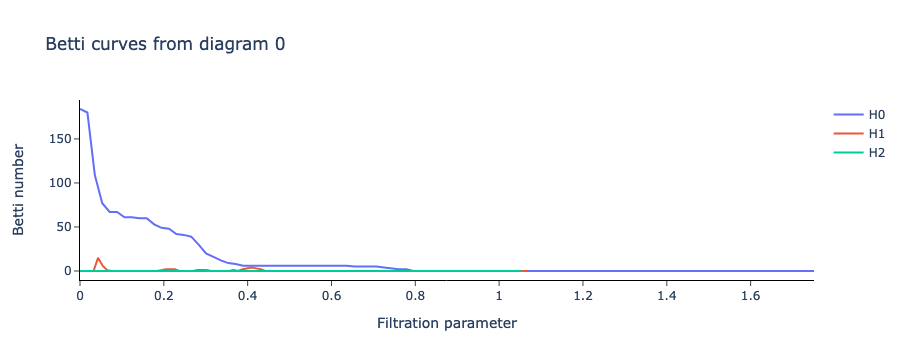

In [141]:
betti_curve = BC.fit_transform_plot(extended_persistence_diagrams["Label_4"])

# Persistence Images

In [39]:
PI = PersistenceImage(sigma=0.2, n_bins=100)

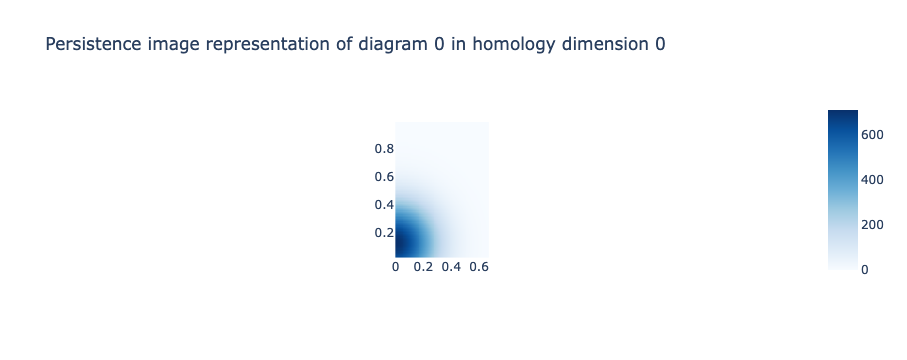

In [143]:
persistence_image = PI.fit_transform_plot(extended_persistence_diagrams["Label_0"])

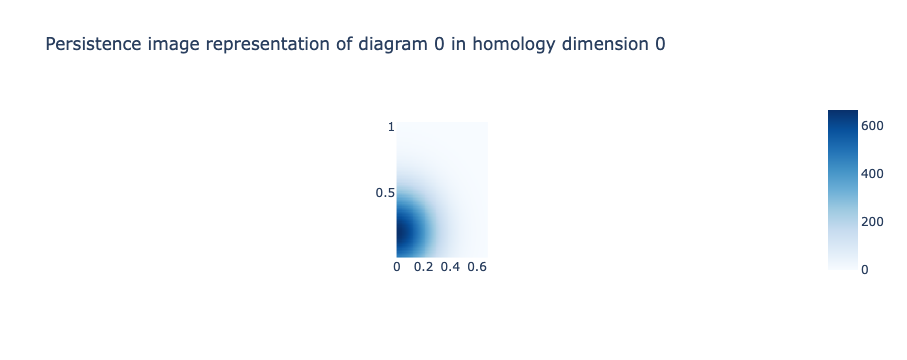

In [144]:
persistence_image = PI.fit_transform_plot(extended_persistence_diagrams["Label_1"])

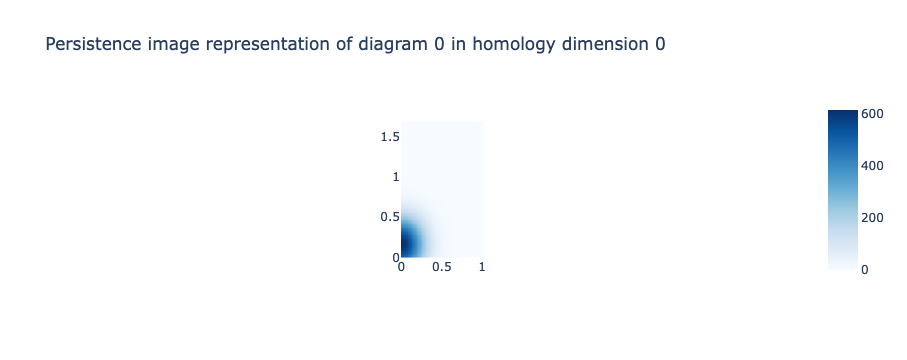

In [145]:
persistence_image = PI.fit_transform_plot(extended_persistence_diagrams["Label_2"])

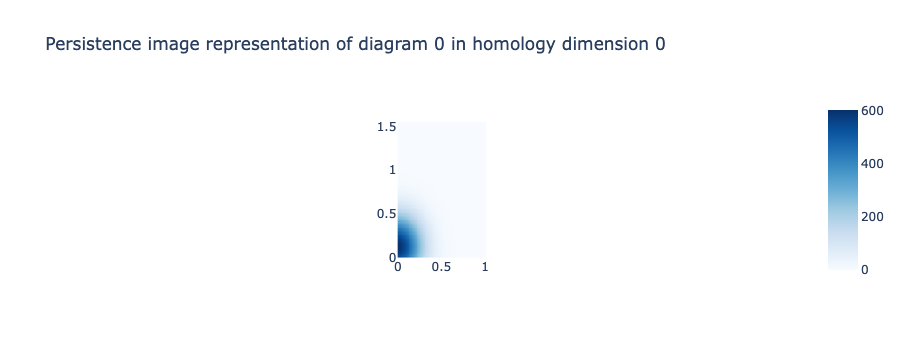

In [146]:
persistence_image = PI.fit_transform_plot(extended_persistence_diagrams["Label_3"])

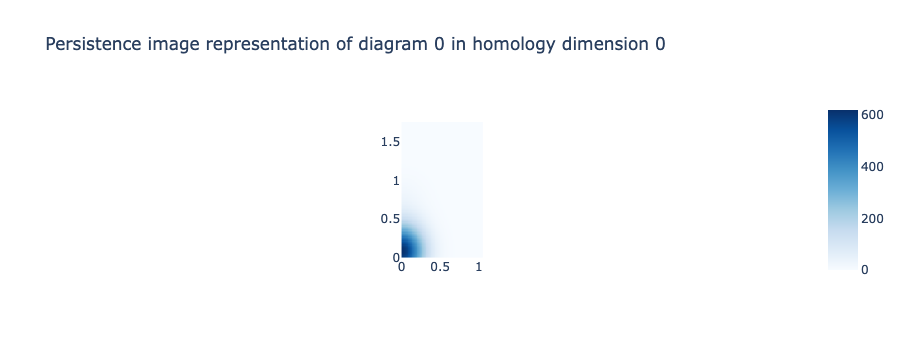

In [147]:
persistence_image = PI.fit_transform_plot(extended_persistence_diagrams["Label_4"])

# Dimensionality reduced visualizations of Signature Vectorizations

First of all, combine all (extended persistence diagrams) to later examine the visualizations for clusters.

In [21]:
all_extended_diagrams = []

for label in label_list:
    all_extended_diagrams = all_extended_diagrams + extended_persistence_diagrams["Label_"+str(label)]

In [215]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Importing this for 3D plotting
import umap.umap_ as umap  # Correcting the import for UMAP

def separate_signature_according_to_dimension(signature):
    """
    Separate the landscape vectors according to each dimension.

    Parameters:
    - signature (list): Signature vector.

    Returns:
    - vectors (dict): Dictionary containing lists of vectors for each dimension.
    """
    vectors = {}
    
    for hom_dim in range(3):
        vectors["Dimension_" + str(hom_dim)] = []
        
        for vector_for_single_diagram in signature:
            vectors["Dimension_" + str(hom_dim)].append(vector_for_single_diagram[hom_dim])
    
    return vectors

def compute_umap_embedding(complete_data, data_list, homology_dimension, random_state=1):
    """
    Perform UMAP dimensionality reduction to 3 dimensions.

    Parameters:
    - signature (list): List containing the signature data.

    Returns:
    - embedding (numpy array): The 3-dimensional UMAP embedding.
    """
    # Perform UMAP dimensionality reduction to 3 dimensions


    reducer = umap.UMAP(n_components=3, random_state=random_state)
    
    reducer.fit(complete_data)
    
    embeddings = []

    for label in range(5):
        embeddings.append(reducer.transform(data_list["Label_"+str(label)]["Dimension_"+str(homology_dimension)]))
    
    return embeddings


def visualize_embedding(list_of_embeddings, title="Signature"):
    """
    Visualize two 3-dimensional UMAP embeddings in the same plot.

    Parameters:
    - list_of_embeddings (list): List of arrays with the first 3-dimensional UMAP embedding.
    - title (str): Title for the plot.

    Returns:
    None
    """
    # Visualize the embeddings
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plots for each label
    for i, embedding in enumerate(list_of_embeddings):
        ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], label=f'Label {i}', color=['blue', 'blueviolet', 'purple', 'crimson', 'red'][i])

    ax.set_xlabel('Dimension 1', fontsize=18)
    ax.set_ylabel('Dimension 2', fontsize=18)
    ax.set_zlabel('Dimension 3', fontsize=18)
    ax.set_title("")

    ax.set_box_aspect([1,1,1])  # Equal aspect ratio

    plt.tick_params(axis='both', which='major', labelsize=15)
    ax.legend(fontsize=13)

    plt.savefig('Plots/'+str(title)+'.png', bbox_inches='tight')

    plt.show()



def compute_kernel_pca_embedding(complete_data, data_list, homology_dimension, kernel='rbf', n_components=3):
    """
    Compute a Kernel PCA reduced embedding with 3 dimensions.
    
    Parameters:
        data (numpy.ndarray): Input data matrix of shape (n_samples, n_features).
        kernel (str): Kernel function to be used ('rbf', 'poly', 'sigmoid', 'linear').
        n_components (int): Number of components for dimensionality reduction.
        
    Returns:
        numpy.ndarray: Kernel PCA reduced embedding of shape (n_samples, 3).
    """
    # Initialize Kernel PCA with specified kernel function
    kpca = KernelPCA(kernel=kernel, n_components=n_components, random_state=42)

    kpca.fit(complete_data[0][homology_dimension])
    
    # Fit and transform the data
    embeddings = []

    for label in range(5):
        embeddings.append(kpca.transform(data_list["Label_"+str(label)][0][homology_dimension]))
    
    return embeddings
    


## Betti Curve

In [197]:
BC = BettiCurve()

In [216]:
curves = {}

for label in range(5):
    curves["Label_"+str(label)] = BC.fit_transform(extended_persistence_diagrams["Label_"+str(label)])

vectors = {}

for label in range(5):
    vectors["Label_"+str(label)]  = separate_signature_according_to_dimension(curves["Label_"+str(label)])

/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


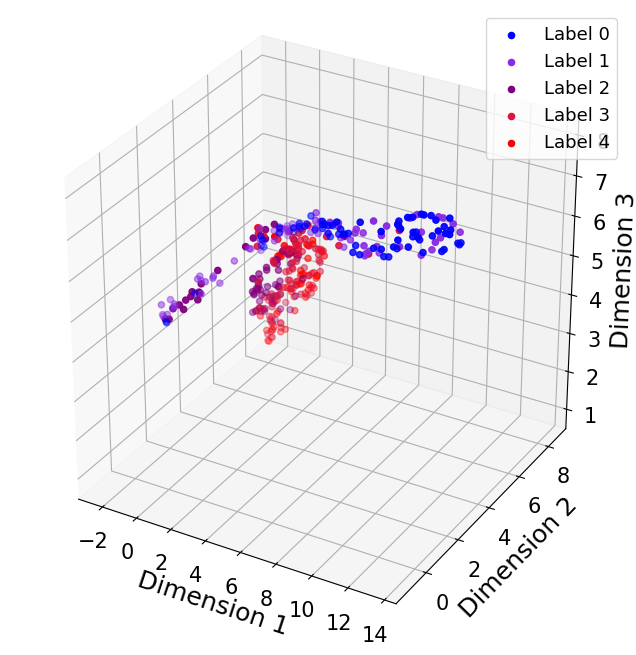

In [217]:
hom_dim = 0

all_vectors = []

for label in range(5):
    all_vectors.extend(vectors["Label_"+str(label)]["Dimension_"+str(hom_dim)])

# Compute combined representation
embedding_list = compute_umap_embedding(all_vectors, vectors, hom_dim)

fig = visualize_embedding(embedding_list, "Dimensionality Reduced Betti Curve of Dimension "+str(hom_dim))


/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


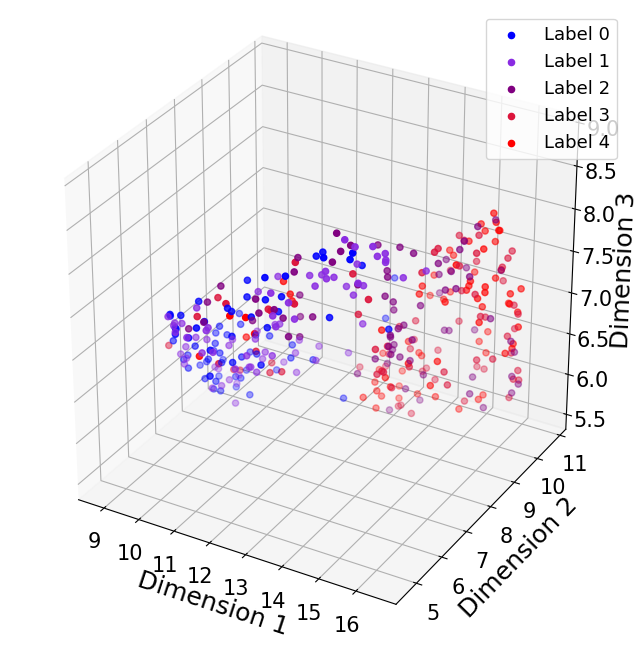

In [218]:
hom_dim = 1

all_vectors = []

for label in range(5):
    all_vectors.extend(vectors["Label_"+str(label)]["Dimension_"+str(hom_dim)])

# Compute combined representation
embedding_list = compute_umap_embedding(all_vectors, vectors, hom_dim)

fig = visualize_embedding(embedding_list, "Dimensionality Reduced Betti Curve of Dimension "+str(hom_dim))


/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


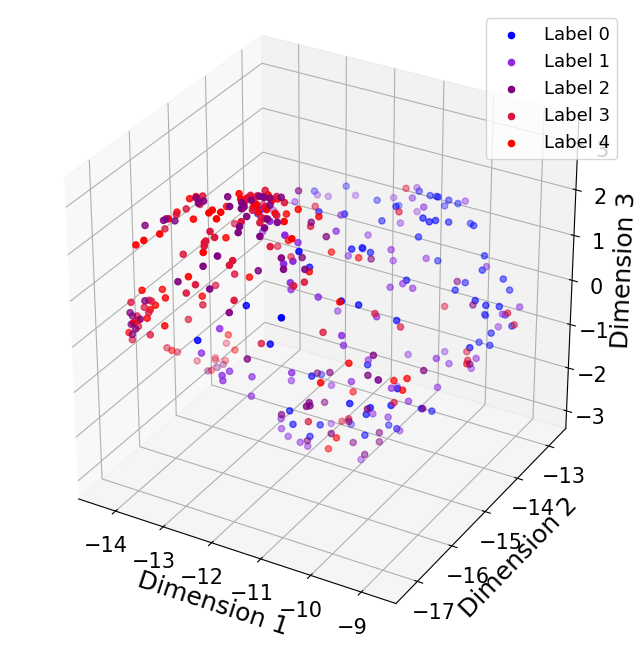

In [219]:
hom_dim = 2

all_vectors = []

for label in range(5):
    all_vectors.extend(vectors["Label_"+str(label)]["Dimension_"+str(hom_dim)])

# Compute combined representation
embedding_list = compute_umap_embedding(all_vectors, vectors, hom_dim)

fig = visualize_embedding(embedding_list, "Dimensionality Reduced Betti Curve of Dimension "+str(hom_dim))


## Silhouette

In [220]:
SH = Silhouette()

In [221]:
curves = {}

for label in range(5):
    curves["Label_"+str(label)] = SH.fit_transform(extended_persistence_diagrams["Label_"+str(label)])

vectors = {}

for label in range(5):
    vectors["Label_"+str(label)]  = separate_signature_according_to_dimension(curves["Label_"+str(label)])

/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


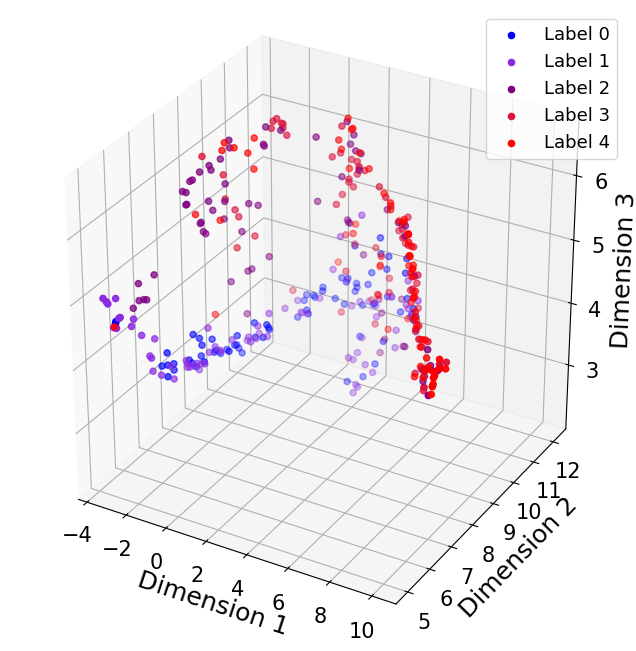

In [222]:
hom_dim = 0

all_vectors = []

for label in range(5):
    all_vectors.extend(vectors["Label_"+str(label)]["Dimension_"+str(hom_dim)])

# Compute combined representation
embedding_list = compute_umap_embedding(all_vectors, vectors, hom_dim)

fig = visualize_embedding(embedding_list, "Dimensionality Reduced Silhouette of Dimension "+str(hom_dim))


/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


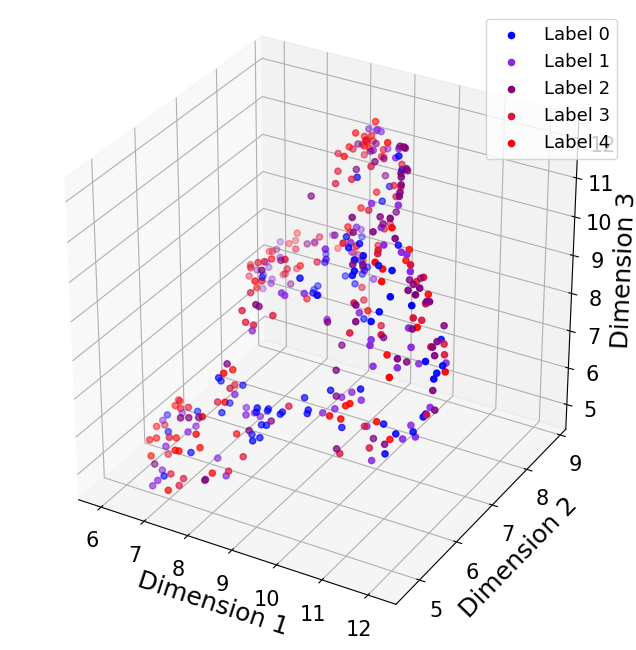

In [223]:
hom_dim = 1

all_vectors = []

for label in range(5):
    all_vectors.extend(vectors["Label_"+str(label)]["Dimension_"+str(hom_dim)])

# Compute combined representation
embedding_list = compute_umap_embedding(all_vectors, vectors, hom_dim)

fig = visualize_embedding(embedding_list, "Dimensionality Reduced Silhouette of Dimension "+str(hom_dim))


/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


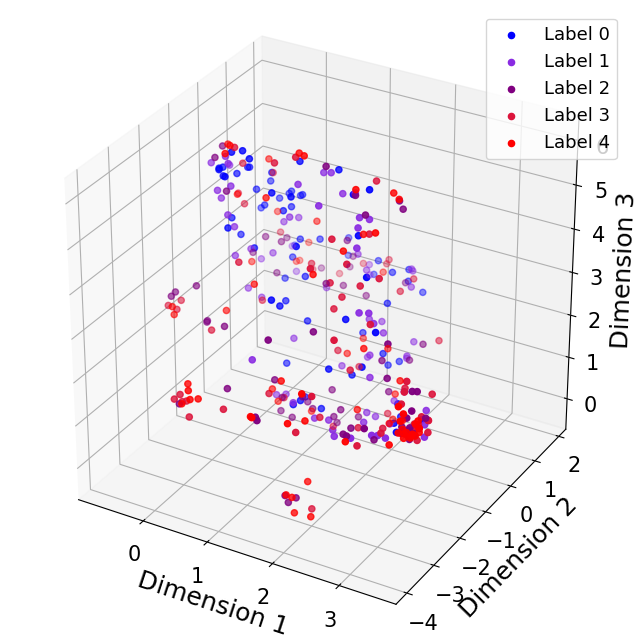

In [224]:
hom_dim = 2

all_vectors = []

for label in range(5):
    all_vectors.extend(vectors["Label_"+str(label)]["Dimension_"+str(hom_dim)])

# Compute combined representation
embedding_list = compute_umap_embedding(all_vectors, vectors, hom_dim)

fig = visualize_embedding(embedding_list, "Dimensionality Reduced Silhouette of Dimension "+str(hom_dim))


## Landscape

In [225]:
PL = PersistenceLandscape()

In [226]:
curves = {}

for label in range(5):
    curves["Label_"+str(label)] = PL.fit_transform(extended_persistence_diagrams["Label_"+str(label)])

vectors = {}

for label in range(5):
    vectors["Label_"+str(label)]  = separate_signature_according_to_dimension(curves["Label_"+str(label)])

/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


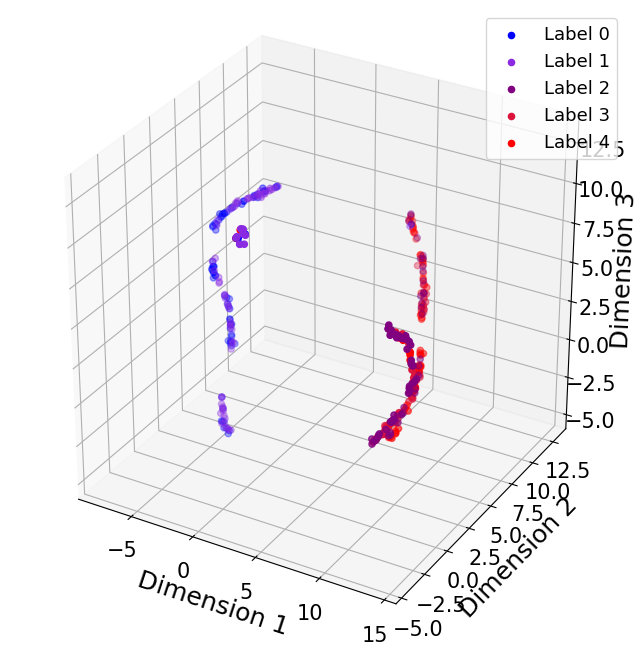

In [227]:
hom_dim = 0

all_vectors = []

for label in range(5):
    all_vectors.extend(vectors["Label_"+str(label)]["Dimension_"+str(hom_dim)])

# Compute combined representation
embedding_list = compute_umap_embedding(all_vectors, vectors, hom_dim)

fig = visualize_embedding(embedding_list, "Dimensionality Reduced Landscape of Dimension "+str(hom_dim))

/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


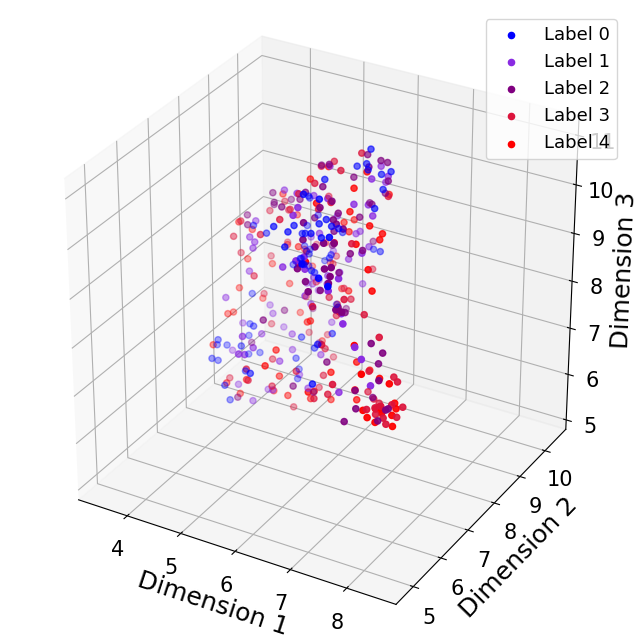

In [228]:
hom_dim = 1

all_vectors = []

for label in range(5):
    all_vectors.extend(vectors["Label_"+str(label)]["Dimension_"+str(hom_dim)])

# Compute combined representation
embedding_list = compute_umap_embedding(all_vectors, vectors, hom_dim)

fig = visualize_embedding(embedding_list, "Dimensionality Reduced Landscape of Dimension "+str(hom_dim))

/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


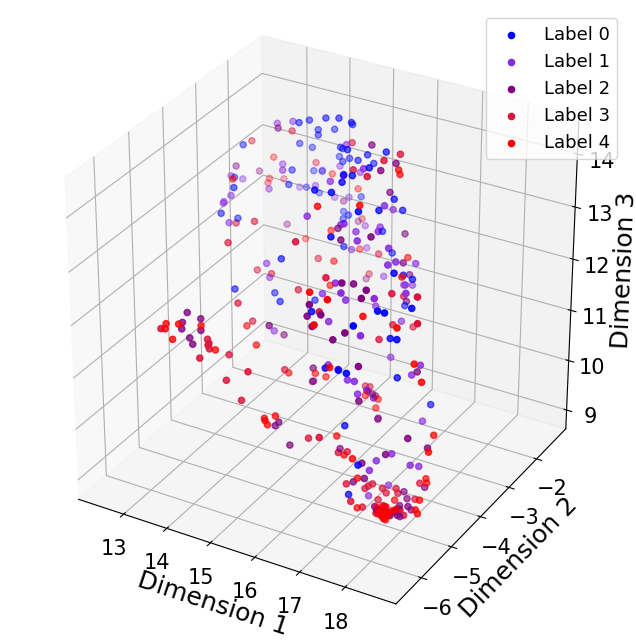

In [229]:
hom_dim = 2

all_vectors = []

for label in range(5):
    all_vectors.extend(vectors["Label_"+str(label)]["Dimension_"+str(hom_dim)])

# Compute combined representation
embedding_list = compute_umap_embedding(all_vectors, vectors, hom_dim)

fig = visualize_embedding(embedding_list, "Dimensionality Reduced Landscape of Dimension "+str(hom_dim))